<center>
<h1 style="font-family:verdana">
 💻 🧑 Reconeixement d'entitats anomenades 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta segona part de la pràctica aprendrem a reconèixer entitats anomenades, és a dir, identificar i classificar entitats en una oració que poden ser (en el context de reserva de vols) la ciutat de sortida o d'arribada, la data del mes i el dia, si es de negocis o turista o altres categories específiques. Aquesta tasca se sol plantejar etiquetant cada paraula amb una etiqueta de la categoria de l'entitat a la qual correspon.

Tant la classificació d'intencions (tasca estudiada a la primera part) com el reconeixement d'entitats anomenades (Name Entity Recognition, NER) que veurem en aquesta part són components crucials dels sistemes de processament del llenguatge natural (Natural Language Processing, NLP) i sovint s'utilitzen junts per crear aplicacions d'intel·ligència artificial (IA) conversacionals més sofisticades. Per exemple, en un xatbot, la classificació d'intencions ajuda a entendre la intenció principal de l'usuari, mentre que el reconeixement d'entitats anomenades ajuda a extreure entitats rellevants per proporcionar respostes més contextualitzades.


<p> ✨ <b>Contingut</b>: els passos d'aquesta segona part seran similars a la primera. En primer lloc, analitzarem el conjunt de dades. En segon lloc, prepararem les dades per a poder entrenar el model. I finalment dissenyarem l'arquitectura i entrenarem el model. </p>


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>

---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
  * [Exercici 2](#ex-two)
2. [Preprocessament de dades](#section-two)
  * [Exercici 3](#ex-three)
  * [Exercici 4](#ex-four)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 5](#ex-five)
  * [Exercici 6](#ex-six)
4. [Lliurable](#section-four)

---

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, LeakyReLU, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D,GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt

<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

In [1]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /content/nlu_ATIS_data.tar.gz
100% 122k/122k [00:00<00:00, 37.4MB/s]


In [ ]:
!ls data

test.csv  train.csv


En aquesta segona part de la pràctica utilitzarem el mateix dataset que a la primera part, però en aquest cas utilitzarem la **primera columna** que correspon a les **oracions** introduïdes pels usuaris i la **segona columna** on trobarem les oracions d'entrada en format **BILOU**.

El format BILOU  és un esquema d'etiquetatge que es fa servir a les tasques de reconeixement d'entitats anomenades. El nom *BILOU* representa les etiquetes utilitzades en aquest esquema:

*   **B** - Beginning: primer token d'una entitat.
*   **I** - Inside: token dins d'una entitat.
*   **L** - Last: últim token de l'entitat.
*   **O** - Outside: token que no pertany a cap entitat.
*   **U** - Unit: entitats d'un sol token

A continuació, carregarem les dades per visualitzar i poder entendre millor aquestes etiquetes.

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

A continuació us demanem que carregueu els dos CSVs de la carpeta `data`: `train.csv`, `test.csv` utilitzant pandas. Recorda que aquests CSVs no tenen capçalera. Agafeu les 900 últimes lineas del fitxer `train.csv` per crear un dataframe per validació.

In [ ]:
#test_data

In [4]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Tal com hem introduït abans, per a aquest exercici ens centrarem en la **primera** i la **segona** columna. Per tant, ara us demanem que guardeu en les següents variables, les llistes corresponents a les oracions i a les etiquetes de les tres particions (`train`, `validation` i `test`).

In [5]:
random_number = random.randint(0, len(train_data)-1)
print('Random number:', random_number)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[1])
# train_labels = list(s.replace(' ', '') for s in train_labels)

val_sentences = list(val_data[0])
val_labels = list(s.replace('"', '') for s in val_data[1])
# val_labels = list(s.replace(' ', '') for s in val_labels)

test_sentences = list(test_data[0])
test_labels = list(s.replace('"', '') for s in test_data[1])
# test_labels = list(s.replace(' ', '') for s in test_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Random number: 482
Sentence:  show me ground transportation in dallas please
Intent:   O O O O O B-city_name O


---

Si tot ha anat bé ja podem analitzar quin aspecte té el format BILOU.

In [ ]:
print(train_sentences[0])
print(train_labels[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day


Aquest hauria de ser el resultat obtingut si executeu la cel·la anterior:

```


i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 "O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day"


```

En aquest exemple, `boston` i `838 am` corresponen a l'entitat "ciutat de sortida" i a l'entitat "hora de sortida" respectivament (`fromloc.city_name`,`depart_time.time`). `838` correspon al primer token que pertany la entitat `depart_time.time` i `am` al segon de la mateixa entitat. Els tokens com `i` o `want` no pertanyen a cap entitat.

In [ ]:
print(train_sentences[1])
print(train_labels[1])

what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day


I aquest hauria de ser el resultat de la cel·la anterior:

```
what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day
```

En l'anterior exemple, `what`, `flights`, `are`, `available`, `from`, `to` i `on` estan etiquetades com a no pertanyents a cap entitat. I, en canvi, `pittsburgh` pertany a l'entitat d'un sol token anomenada ciutat d'arribada (`toloc.city_name`). També hi ha entitats compostes com `baltimore` que pertany a l'entitat ciutat de sortida (`fromloc.city_name`) i `thursday morning` que pertanyen a les entitats data de sortida (`depart_date.day_name`, `depart_time.period_of_day`).

Vegem-ne la llista completa d'entitats.

In [6]:
from collections import Counter

def count_unique_entities(list_of_label_sentences):
  flat_labels = []
  for labels in list_of_label_sentences:
    flat_labels += labels.split()
  c = Counter(flat_labels)
  return len(c), list(c.keys())

num_unique_entities, unique_entities = count_unique_entities(train_labels)

print("Number of different entities:", num_unique_entities)

print("Unique entities:", unique_entities)

Number of different entities: 119
Unique entities: ['O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B-flight_m

<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

El processament de les dades serà semblant al de la primera part d'aquesta pràctica.

---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

En aquest exercici us demanem que realitzeu els passos següents per preparar les dades.

 1. El primer pas serà construir el vocabulari a partir de les paraules presents a les oracions d'entrenament.

2. El segon pas serà convertir les oracions en seqüències de nombres enters usant el tokenitzador.

3. El tercer pas serà guardar la longitud original de cada oració. Això ens serà útil per evaluar el nostre model sense tenir en compte el padding.

3. Finalment, per aconseguir que totes les seqüències tinguen la mateixa longitud, fixarem la longitud segons la màxima trobada a l'entrenament i afegirem zeros a les oracions de menor longitud.

Recordeu que podeu consultar com fer-ho a la documentació de la llibrería:
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer"> Tokenizer </a>
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences"> Pad Sequences </a>




In [7]:
#TODO
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
len_train_sequences = [len(seq) for seq in train_sequences]
max_sequence_length = max(len_train_sequences)
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

val_sequences = tokenizer.texts_to_sequences(val_sentences)
len_val_sequences = [len(seq) for seq in val_sequences]
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')


test_sequences = tokenizer.texts_to_sequences(test_sentences)
len_test_sequences = [len(seq) for seq in test_sequences]
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')


{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

In [ ]:
train_pad_sequences[0]

array([ 12,  69,   1,  38,   2,   9,  64, 415,  84,  17,  75,  16,  13,
        64, 493,  16,   4,  36,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=int32)


---



Tal com vam fer a la primera part, aquí també hem de convertir les diferents classes d'entitats en vectors one-hot.

---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

Per aconseguir-ho haureu de seguir els passos següents.

 1. En primer lloc, haureu d'esbrinar quantes etiquetes diferents hi ha. Podeu prendre com a exemple la funció `count_unique_entities` per fer-ho. Tingueu en compte que haureu de modificar la funció, ja que per exemple aquesta funció considera que `B-depart_time.time`, `I-depart_time.time`, `L-depart_time.time`, `U-depart_time.time` són la mateixa entitat. En aquest exercici, necessitarem comptar-les per separat. També l'entitat O ha de ser considerada com una classe.

 2. El segon pas serà codificar les diferents classes trobades en etiquetes numèriques. Tingueu en compte que cada paraula de l'oració té una etiqueta i, per tant, per a cada oració tindrem una llista d'etiquetes. El *padding* el codificarem amb l'etiqueta corresponent a **O** (outside). Per ajudar-vos hem preparat el processament per a les etiquetes d'entrenament, intenteu comprendre el que es fa i així repetir-ho per a la partició de validació i test.

 3. Finalment, haureu de convertir les diferents classes a vectors one-hot. Recordeu de nou que per a cada oració tindrem una llista de vectors one-hot.


 Podeu consultar els apartats de la documentació:
 * <a href=https://www.tensorflow.org/guide/keras/understanding_masking_and_padding> Masking and Padding </a>

 * <a href=https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical> To Categorical </a>



In [8]:
#Step 1
def count_unique_entities(list_of_label_sentences):
    unique_entities = set()
    for sentence_labels in list_of_label_sentences:
        entity_labels = sentence_labels.split()
        for label in entity_labels:
            unique_entities.add(label)
    unique_entities = ['<pad>']+(list(unique_entities))

    return len(unique_entities), unique_entities

num_unique_entities, unique_entities = count_unique_entities(train_labels)

print("Number of different entities:", num_unique_entities)
print("Unique entities:", unique_entities)

#Step 2
label_encoder = LabelEncoder()
label_encoder.fit(list(unique_entities))
_train_labels = [label.split() for label in train_labels]
train_numerical_labels = [label_encoder.transform(label) for label in _train_labels]
train_pad_labels = pad_sequences(train_numerical_labels, maxlen=max_sequence_length, padding='post',value=119)

def remove_sentences(list_labels, list_sequences):
  idx_to_remove = []
  labels_to_remove = []
  for idx, labels in enumerate(list_labels):
    for label in labels:
      if label not in unique_entities:
        idx_to_remove.append(idx)
        labels_to_remove.append(label)

  labels = [elem for i, elem in enumerate(list_labels) if i not in idx_to_remove]
  sequences = [elem for i, elem in enumerate(list_sequences) if i not in idx_to_remove]
  return labels, np.array(sequences)

_test_labels = [label.split() for label in test_labels]
test_labels_n, test_pad_sequences = remove_sentences(_test_labels, test_pad_sequences)
test_numerical_labels = [label_encoder.transform(label) for label in test_labels_n]
test_pad_labels = pad_sequences(test_numerical_labels, maxlen=max_sequence_length, padding='post',value=119) #119 es el index de pad

_val_labels = [label.split() for label in val_labels]
val_labels_n, val_pad_sequences = remove_sentences(_val_labels, val_pad_sequences)
val_numerical_labels = [label_encoder.transform(label) for label in val_labels_n]
val_pad_labels = pad_sequences(val_numerical_labels, maxlen=max_sequence_length, padding='post',value=119)


#Step 3
train_labels_one_hot = to_categorical(train_pad_labels, num_classes=num_unique_entities)
test_labels_one_hot = to_categorical(test_pad_labels, num_classes=num_unique_entities)
val_labels_one_hot = to_categorical(val_pad_labels, num_classes=num_unique_entities)

print(train_pad_labels[0])

print(train_labels_one_hot[0][0])

Number of different entities: 120
Unique entities: ['<pad>', 'B-arrive_time.time_relative', 'I-mod', 'B-stoploc.airport_name', 'B-month_name', 'I-fare_amount', 'I-arrive_time.start_time', 'I-depart_date.day_name', 'B-today_relative', 'I-fromloc.city_name', 'B-toloc.airport_code', 'I-depart_time.time_relative', 'B-fare_basis_code', 'B-return_time.period_of_day', 'B-arrive_time.time', 'B-connect', 'B-arrive_date.date_relative', 'B-meal_description', 'I-time', 'B-meal', 'B-meal_code', 'B-flight_time', 'B-airport_name', 'B-round_trip', 'B-fromloc.airport_code', 'B-arrive_date.day_name', 'B-depart_time.time_relative', 'B-days_code', 'B-toloc.city_name', 'I-airport_name', 'I-toloc.city_name', 'B-state_name', 'B-fromloc.city_name', 'B-flight_days', 'I-round_trip', 'I-flight_stop', 'B-fromloc.airport_name', 'B-depart_time.period_mod', 'B-toloc.country_name', 'I-toloc.state_name', 'I-depart_time.end_time', 'I-fromloc.state_name', 'B-arrive_date.day_number', 'B-arrive_time.period_mod', 'B-arrive

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

---
<h1><a name="ex-five"><center> ✏ Exercici 5 ✏</a></h1>

De forma similar com féreu a la primera part de la pràctica us demanem que dissenyeu l'arquitectura i entreneu el model. Podeu fer servir una arquitectura similar. Ara bé, per capturar les dependències seqüencials podeu canviar la capa de GlobalMaxPooling1D per una LSTM.

In [ ]:
s = train_pad_labels.shape
train_flat_labels = train_pad_labels.reshape(s[0]*s[1])
train_unq_labels = np.unique(train_flat_labels)
print(train_flat_labels.shape, train_unq_labels)

(183510,) [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119]


In [9]:
class TransformerBlock(keras.layers.Layer):  #si cambiamos mida embbedings hay que cambiarlo aqui tmb
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"), #alomejor hacer bottleneck o al reves primero expandir y luego bottleneck
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings





In [ ]:
#TODO

embedding_dim = 32
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

#hacer bn

model = Sequential()

# model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, mask_zero=True))
# model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units=num_unique_entities, activation='softmax'))

# Capa d'Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
# Capa de LSTM
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
# model.add(Dropout(0.2))
# Flatten layer to convert 3D tensor to 2D
# model.add(Flatten())
# Capa Densa amb activació ReLU
model.add(Dense(64, activation='relu'))
# Capa de sortida amb Softmax
model.add(Dense(num_unique_entities, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 30
model.fit(train_pad_sequences, train_labels_one_hot, validation_data=(val_pad_sequences, val_labels_one_hot), batch_size=batch_size, epochs=epochs)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot,batch_size=batch_size)
print(f"Test accuracy: {accuracy:.2f}, loss: {loss:.2f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
  4/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2319 - loss: 4.7704  

KeyboardInterrupt: 

In [ ]:
preds = model.predict(test_pad_sequences)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
preds.shape

(885, 45, 120)

In [10]:
def preds_to_index(preds, seq_lens):
  '''
  Turn predictions to numerical indexes, flatten the sentences and discard padding.
  '''
  idx_preds = []
  for pred, seq_len in zip(preds,seq_lens):
      for l in range(seq_len):
        idx_preds.append(np.argmax(pred[l]))
  return idx_preds



Com ja sabeu, NER es una tasca on les dades estan molt desbalancejades. La gran majoria de les nostres etiquetes serán 'O' (outside). Es pot donar el cas on el model tingui una accuracy molt alta predint sempre 'O'.

Per mesurar millor com de bó és el nostre model, calcularem la F1 score per cada classe, així com la mitjana (macro average). Quan prepareu el vostre document, heu de reportar aquesta mitjana com a mètrica del vostre model, no l'acuracy.

In [ ]:
test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

labels_to_use = [lbl for lbl in set(test_labels_idx) if lbl != 119]

print(classification_report(test_labels_idx, preds_idx, labels=labels_to_use, target_names=[label_encoder.classes_[i] for i in labels_to_use], zero_division=1.0))


                              precision    recall  f1-score   support

             B-aircraft_code       0.60      0.14      0.23        21
              B-airline_code       0.96      0.76      0.85        29
              B-airline_name       0.94      0.85      0.89        79
              B-airport_code       1.00      0.00      0.00         8
              B-airport_name       0.67      0.44      0.53        18
 B-arrive_date.date_relative       1.00      0.00      0.00         1
      B-arrive_date.day_name       0.83      0.71      0.77         7
    B-arrive_date.day_number       0.67      0.67      0.67         3
    B-arrive_date.month_name       0.50      0.33      0.40         3
 B-arrive_time.period_of_day       1.00      1.00      1.00         2
    B-arrive_time.start_time       1.00      0.00      0.00         1
          B-arrive_time.time       0.77      0.77      0.77        13
 B-arrive_time.time_relative       0.79      0.79      0.79        14
                 B-

lo que quiere es f1 score el macro y el nombre de las etiquetas, la o y padding deberia ser lo mismo y no deberian salir

A continuació podeu veure algunes prediccions del model.

In [ ]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=2)

predicted_labels = [list(label_encoder.inverse_transform(label)) for label in _predicted_labels]

for i in range(0, 10):
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sentence:  i would like to find a flight from charlotte to las vegas that makes a stop in st. louis
Original label:   O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O O O O B-stoploc.city_name I-stoploc.city_name
Predicted label:  [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('B-fromloc.city_name'), np.str_('O'), np.str_('B-toloc.city_name'), np.str_('I-toloc.city_name'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('I-stoploc.city_name'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]

S

---

 <h1><a name="ex-six"><center> ✏ Exercici 6 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 2. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 3. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 4. ** Transformer.** Afegiu blocs de Transformer al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.


 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

### Proba mida Embbedings

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


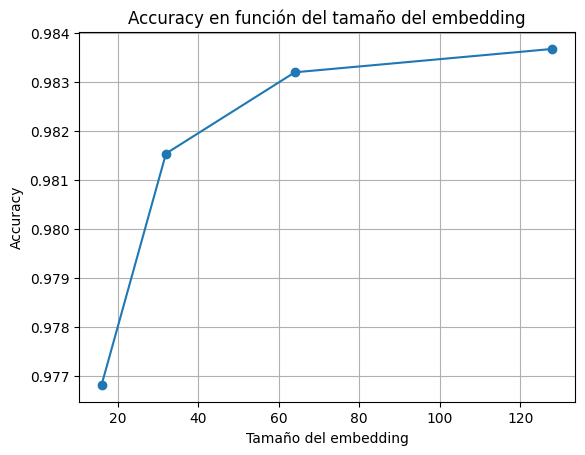

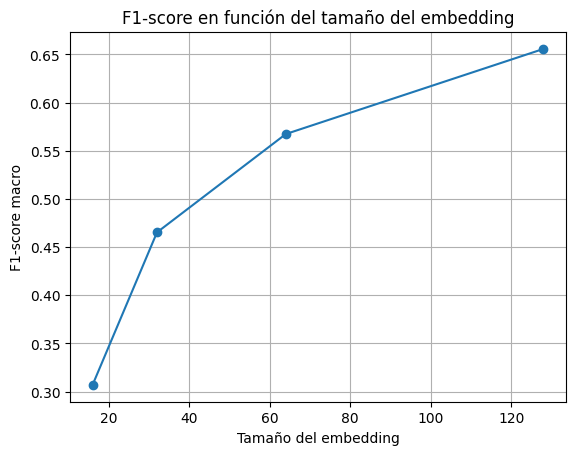

=== Classification report del MEJOR modelo (por F1_macro) ===
                              precision    recall  f1-score   support

             B-aircraft_code       1.00      0.00      0.00        21
              B-airline_code       0.95      0.62      0.75        29
              B-airline_name       0.93      0.85      0.89        79
              B-airport_code       1.00      0.00      0.00         8
              B-airport_name       0.71      0.28      0.40        18
 B-arrive_date.date_relative       1.00      0.00      0.00         1
      B-arrive_date.day_name       0.80      0.57      0.67         7
    B-arrive_date.day_number       0.50      0.33      0.40         3
    B-arrive_date.month_name       0.50      0.33      0.40         3
 B-arrive_time.period_of_day       1.00      1.00      1.00         2
    B-arrive_time.start_time       1.00      0.00      0.00         1
          B-arrive_time.time       0.83      0.77      0.80        13
 B-arrive_time.time_relativ

In [ ]:
import matplotlib.pyplot as plt
vocab_size = len(tokenizer.word_index) + 1
embedding_dims = [16, 32, 64, 128]  # Diferentes tamaños de embedding
accuracies = []  # Lista para almacenar las precisiones
f1_scores = []
best_f1 = -1.0
best_report_text = None

for embedding_dim in embedding_dims:
    # Crear el modelo
    model = Sequential()

    # Capa de Embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    # Capa de LSTM Bidireccional
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

    # Capa Densa con activación ReLU
    model.add(Dense(128, activation='relu'))

    # Capa de salida con Softmax
    model.add(Dense(num_unique_entities, activation='softmax'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(train_pad_sequences, train_labels_one_hot, validation_data=(val_pad_sequences, val_labels_one_hot), batch_size=batch_size, epochs=epochs, verbose=0)

    # Evaluar el modelo en el conjunto de test
    loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size, verbose=0)
    preds = model.predict(test_pad_sequences, batch_size=batch_size, verbose=0)
    test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
    preds_idx = preds_to_index(preds, len_test_sequences)
    labels_to_use = [lbl for lbl in set(test_labels_idx) if lbl != 119]

    rep = classification_report(
    test_labels_idx, preds_idx,
    labels=labels_to_use,
    target_names=[label_encoder.classes_[i] for i in labels_to_use],
    zero_division=1.0,
    output_dict=True)

    f1_macro = rep['macro avg']['f1-score']
    # Almacenar la precisión
    accuracies.append(accuracy)
    f1_scores.append(f1_macro)
    # Guarda el mejor classification_report (por F1_macro) para imprimir al final
    if f1_macro > best_f1:
                best_f1 = f1_macro
                best_report_text = classification_report(
                    test_labels_idx, preds_idx,
                    labels=labels_to_use,
                    target_names=[label_encoder.classes_[i] for i in labels_to_use],
                    zero_division=1.0
                )


# Graficar los resultados
plt.plot(embedding_dims, accuracies, marker='o')
plt.title('Accuracy en función del tamaño del embedding')
plt.xlabel('Tamaño del embedding')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

plt.plot(embedding_dims, f1_scores, marker='o')
plt.title('F1-score en función del tamaño del embedding')
plt.xlabel('Tamaño del embedding')
plt.ylabel('F1-score macro')
plt.grid(True)
plt.show()

print("=== Classification report del MEJOR modelo (por F1_macro) ===")
print(best_report_text)



### Xarxes Convulacionals


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/p

,Filters,Kernel Size,Accuracy,F1_macro
0,32,3,0.984457,0.657385
1,32,5,0.983327,0.637079
2,32,7,0.982900,0.604736
3,64,3,0.983955,0.675674
4,64,5,0.983930,0.667099
5,64,7,0.983327,0.652514
6,128,3,0.983578,0.673570
7,128,5,0.984432,0.674043
8,128,7,0.984256,0.645226


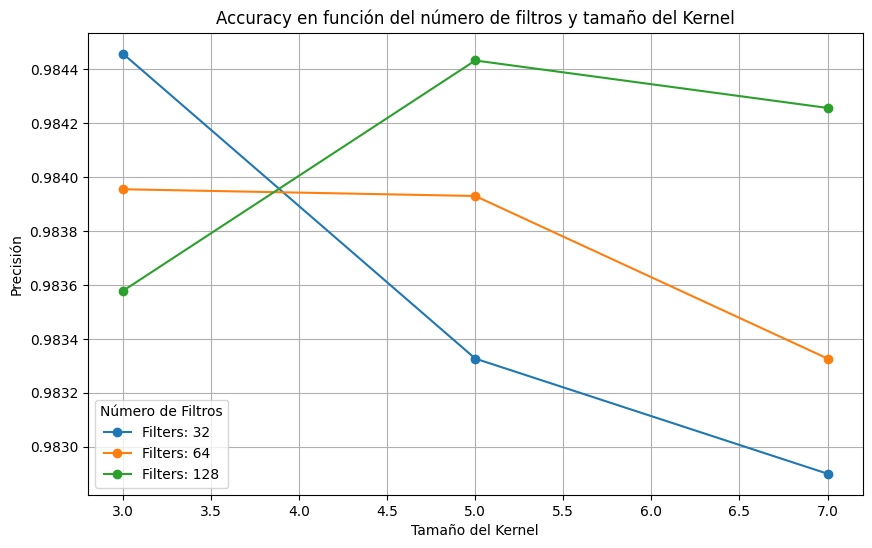

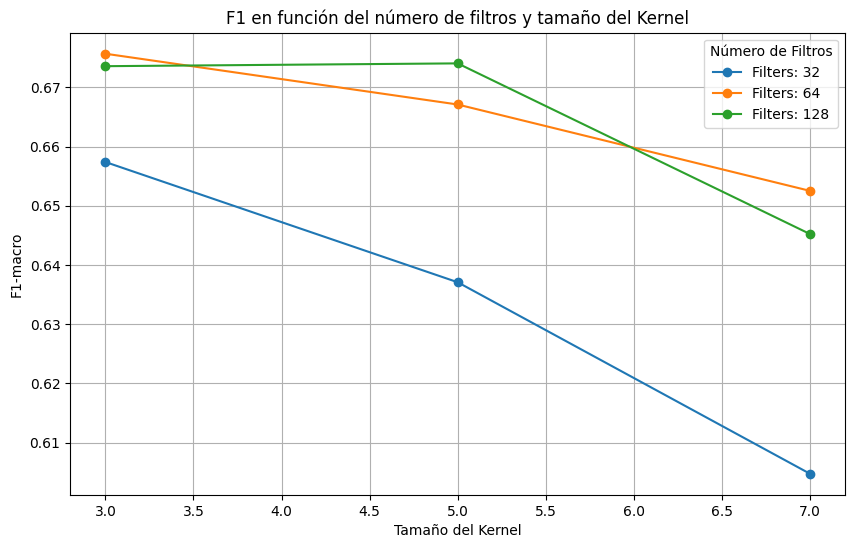

=== Classification report del MEJOR modelo (por F1_macro) ===
                              precision    recall  f1-score   support

             B-aircraft_code       0.75      0.14      0.24        21
              B-airline_code       0.96      0.76      0.85        29
              B-airline_name       0.96      0.85      0.90        79
              B-airport_code       0.50      0.38      0.43         8
              B-airport_name       0.80      0.22      0.35        18
 B-arrive_date.date_relative       1.00      0.00      0.00         1
      B-arrive_date.day_name       0.75      0.43      0.55         7
    B-arrive_date.day_number       1.00      0.33      0.50         3
    B-arrive_date.month_name       0.67      0.67      0.67         3
 B-arrive_time.period_of_day       1.00      1.00      1.00         2
    B-arrive_time.start_time       0.50      1.00      0.67         1
          B-arrive_time.time       0.77      0.77      0.77        13
 B-arrive_time.time_relativ

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
vocab_size = len(tokenizer.word_index) + 1
batch_size = 32
epochs = 15
embedding_dim = 128
filter_sizes = [32, 64, 128]
kernel_sizes = [3, 5, 7]

results = []
best_f1 = -1.0
best_report_text = None

for filters in filter_sizes:
    for kernel_size in kernel_sizes:
        model = Sequential()
        # Embedding con máscara para ignorar padding (id 0)
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            input_length=max_sequence_length))

        model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                         padding='same', activation='relu'))

        # BiLSTM manteniendo la secuencia completa (shape: B, 45, 128)
        # model.add(Bidirectional(LSTM(units=64, return_sequences=True)))


        # model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                        #  padding='same', activation='relu'))
        # model.add(GlobalMaxPooling1D())


        model.add(Dense(128, activation='relu'))
        # Predicción por token -> (B, 45, 120)
        model.add(Dense(num_unique_entities, activation='softmax'))

        # Usa la loss según el formato de tus etiquetas:
        # - Si y es one-hot: shape (B, 45, 120)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # - Si y son enteros (no one-hot), cambia a:
        # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        model.fit(train_pad_sequences, train_labels_one_hot,
                  validation_data=(val_pad_sequences, val_labels_one_hot),
                  batch_size=batch_size, epochs=epochs, verbose=0)

        loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot,
                                        batch_size=batch_size, verbose=0)

        preds = model.predict(test_pad_sequences, batch_size=batch_size, verbose=0)
        test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
        preds_idx = preds_to_index(preds, len_test_sequences)
        labels_to_use = [lbl for lbl in set(test_labels_idx) if lbl != 119]

        rep = classification_report(
        test_labels_idx, preds_idx,
        labels=labels_to_use,
        target_names=[label_encoder.classes_[i] for i in labels_to_use],
        zero_division=1.0,
        output_dict=True
        )
        f1_macro = rep['macro avg']['f1-score']

        results.append({
          'Filters': filters,
          'Kernel Size': kernel_size,
          'Accuracy': accuracy,
          'F1_macro': f1_macro
            })

        if f1_macro > best_f1:
                best_f1 = f1_macro
                best_report_text = classification_report(
                    test_labels_idx, preds_idx,
                    labels=labels_to_use,
                    target_names=[label_encoder.classes_[i] for i in labels_to_use],
                    zero_division=1.0
                )



# Convertimos los resultados a un DataFrame
df_results = pd.DataFrame(results)

# Mostrar la tabla
from IPython.display import display
display(df_results)


plt.figure(figsize=(10, 6))
for filters in sorted(df_results['Filters'].unique()):
    subset = df_results[df_results['Filters'] == filters].sort_values('Kernel Size')
    if len(subset) == 0:
        continue
    plt.plot(subset['Kernel Size'], subset['Accuracy'], label=f'Filters: {filters}', marker='o')

plt.title('Accuracy en función del número de filtros y tamaño del Kernel')
plt.xlabel('Tamaño del Kernel')
plt.ylabel('Precisión')
plt.legend(title="Número de Filtros")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for filters in sorted(df_results['Filters'].unique()):
      subset = df_results[df_results['Filters'] == filters].sort_values('Kernel Size')
      if len(subset) == 0:
          continue
      plt.plot(subset['Kernel Size'], subset['F1_macro'], label=f'Filters: {filters}', marker='o')

plt.title('F1 en función del número de filtros y tamaño del Kernel')
plt.xlabel('Tamaño del Kernel')
plt.ylabel('F1-macro')
plt.legend(title="Número de Filtros")
plt.grid(True)
plt.show()


print("=== Classification report del MEJOR modelo (por F1_macro) ===")
print(best_report_text)


### `Xarxes Recurrents`

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_44' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12

,Cell,Units,Con_conv,Filters,Kernel,Accuracy,F1_macro
0,LSTM,32,0,64,3,0.984256,0.705247
1,LSTM,32,1,64,3,0.984256,0.671514
2,LSTM,64,0,64,3,0.984256,0.674891
3,LSTM,64,1,64,3,0.984256,0.654846
4,LSTM,128,0,64,3,0.984256,0.658055
5,LSTM,128,1,64,3,0.984256,0.653592
6,GRU,32,0,64,3,0.984256,0.688805
7,GRU,32,1,64,3,0.984256,0.617959
8,GRU,64,0,64,3,0.984256,0.659120
9,GRU,64,1,64,3,0.984256,0.635265


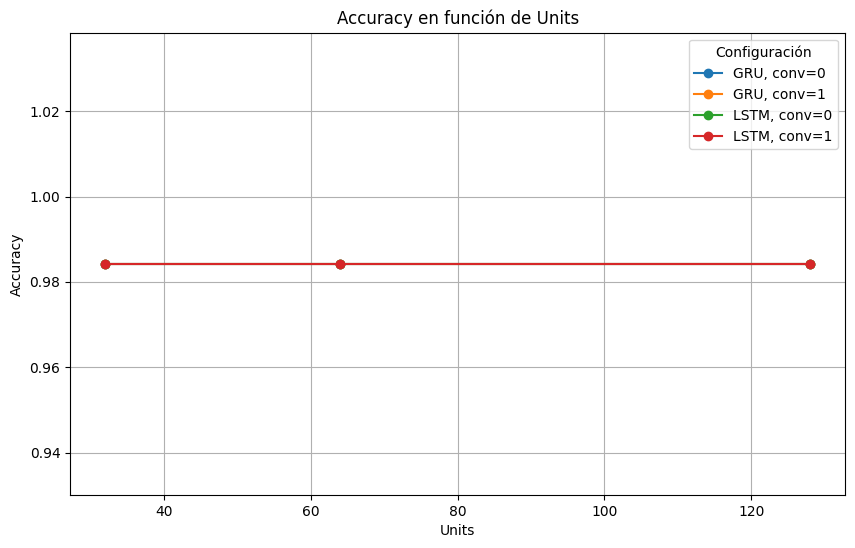

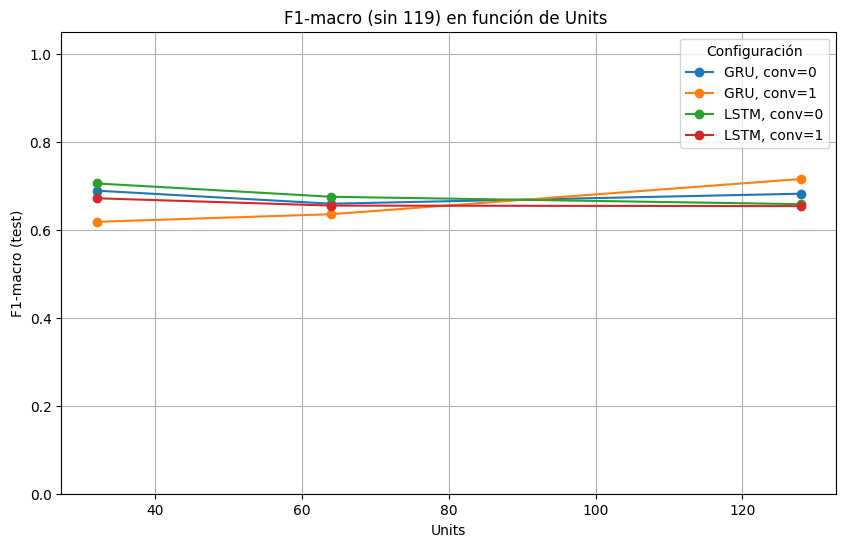

=== Classification report del MEJOR modelo (por F1_macro) ===
                              precision    recall  f1-score   support

             B-aircraft_code       1.00      0.00      0.00        21
              B-airline_code       1.00      0.83      0.91        29
              B-airline_name       0.97      0.85      0.91        79
              B-airport_code       0.50      0.38      0.43         8
              B-airport_name       0.71      0.28      0.40        18
 B-arrive_date.date_relative       0.50      1.00      0.67         1
      B-arrive_date.day_name       0.62      0.71      0.67         7
    B-arrive_date.day_number       1.00      0.67      0.80         3
    B-arrive_date.month_name       0.67      0.67      0.67         3
 B-arrive_time.period_of_day       1.00      1.00      1.00         2
    B-arrive_time.start_time       1.00      1.00      1.00         1
          B-arrive_time.time       0.77      0.77      0.77        13
 B-arrive_time.time_relativ

In [ ]:
import pandas as pd
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
best_filters = 64
best_kernel = 3

RNN = ['LSTM', 'GRU']
units_list = [32,64, 128]
con_conv = [0, 1]



results = []
best_f1 = -1.0
best_report_text = None

def add_recurrent_block(model, cell_type, units, return_sequences=True):
    # Crea una capa recurrente bidireccional con los parámetros dados
    RNN = LSTM if cell_type == 'LSTM' else GRU
    model.add(Bidirectional(RNN(units=units, return_sequences=return_sequences
    )))

for rnn in RNN:
    for units in units_list:
      for conv in con_conv:


                    # Construcción del modelo
                    model = Sequential()
                    # Embedding con máscara para ignorar padding (id 0)
                    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                        input_length=max_sequence_length, mask_zero=True))
                    if conv== 1:

                        model.add(Conv1D(filters=best_filters, kernel_size=best_kernel,
                                         padding='same', activation='relu'))



                    RNN_type = LSTM if rnn == 'LSTM' else GRU
                    model.add(Bidirectional(RNN_type(units=units, return_sequences=True)))


                    # model.add(Conv1D(filters=best_filters, kernel_size=best_kernel,
                    #                      padding='same', activation='relu'))

                    model.add(Dense(128, activation='relu'))
                    # Salida por token
                    model.add(Dense(num_unique_entities, activation='softmax'))

                    # Compilación (usa 'sparse_categorical_crossentropy' si tus y son enteros)
                    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                    # Entrenamiento
                    model.fit(
                        train_pad_sequences, train_labels_one_hot,
                        validation_data=(val_pad_sequences, val_labels_one_hot),
                        batch_size=batch_size, epochs=epochs, verbose=0
                    )

                    # Evaluación
                    loss, acc = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size, verbose=0)

                    preds = model.predict(test_pad_sequences, batch_size=batch_size, verbose=0)
                    test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
                    preds_idx = preds_to_index(preds, len_test_sequences)
                    labels_to_use = [lbl for lbl in set(test_labels_idx) if lbl != 119]

                    rep = classification_report(
                    test_labels_idx, preds_idx,
                    labels=labels_to_use,
                    target_names=[label_encoder.classes_[i] for i in labels_to_use],
                    zero_division=1.0,
                    output_dict=True
                    )
                    f1_macro = rep['macro avg']['f1-score']

                    results.append({
                        'Cell': rnn,
                        'Units': units,
                        'Con_conv': conv,
                        'Filters': best_filters ,
                        'Kernel': best_kernel ,
                        'Accuracy': accuracy,
                        'F1_macro': f1_macro})

                    if f1_macro > best_f1:
                      best_f1 = f1_macro
                      best_report_text = classification_report(
                          test_labels_idx, preds_idx,
                          labels=labels_to_use,
                          target_names=[label_encoder.classes_[i] for i in labels_to_use],
                          zero_division=1.0
                      )

df_results = pd.DataFrame(results)

display(df_results)

#Plot Accuracy
plt.figure(figsize=(10, 6))
for rnn_name in sorted(df_results['Cell'].unique()):
    for conv in sorted(df_results['Con_conv'].unique()):
        sub = df_results[(df_results['Cell'] == rnn_name) & (df_results['Con_conv'] == conv)].sort_values('Units')
        if len(sub) == 0:
            continue
        x = sub['Units'].values
        y = sub['Accuracy'].values
        plt.plot(x, y, marker='o', label=f'{rnn_name}, conv={conv}')
plt.title('Accuracy en función de Units')
plt.xlabel('Units')
plt.ylabel('Accuracy')
plt.legend(title="Configuración")
plt.grid(True)
plt.show()

#Plot F1

plt.figure(figsize=(10, 6))
for rnn_name in sorted(df_results['Cell'].unique()):
    for conv in sorted(df_results['Con_conv'].unique()):
        sub = df_results[(df_results['Cell'] == rnn_name) & (df_results['Con_conv'] == conv)].sort_values('Units')
        if len(sub) == 0:
            continue
        x = sub['Units'].values
        y = sub['F1_macro'].values
        plt.plot(x, y, marker='o', label=f'{rnn_name}, conv={conv}')
plt.title('F1-macro (sin 119) en función de Units ')
plt.xlabel('Units')
plt.ylabel('F1-macro (test)')
plt.ylim(0, 1.05)
plt.legend(title="Configuración")
plt.grid(True)
plt.show()


print("=== Classification report del MEJOR modelo (por F1_macro) ===")
print(best_report_text)


### Transformer

,RNN,Heads,FF_mult,TF_Layers,Accuracy_test,F1_macro
0,GRU,4,2,1,0.985763,0.720093
1,None,4,2,1,0.981318,0.620268
2,GRU,4,2,2,0.984809,0.706916
3,None,4,2,2,0.983578,0.668063
4,GRU,4,4,1,0.984407,0.714081
5,None,4,4,1,0.979335,0.641282
6,GRU,4,4,2,0.983528,0.698115
7,None,4,4,2,0.982875,0.638119
8,GRU,8,2,1,0.984030,0.722097
9,None,8,2,1,0.980791,0.643658


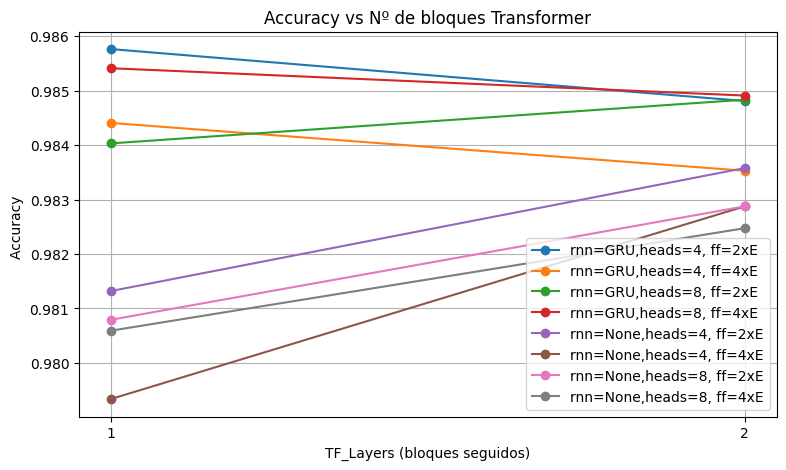

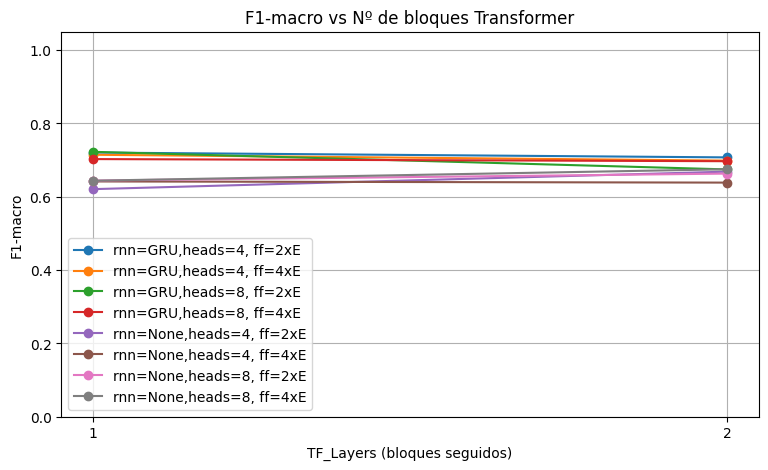

=== Classification report del MEJOR modelo (por F1_macro) ===
                              precision    recall  f1-score   support

             B-aircraft_code       0.25      0.05      0.08        21
              B-airline_code       0.85      0.79      0.82        29
              B-airline_name       0.93      0.82      0.87        79
              B-airport_code       0.75      0.38      0.50         8
              B-airport_name       0.82      0.50      0.62        18
 B-arrive_date.date_relative       1.00      1.00      1.00         1
      B-arrive_date.day_name       0.50      0.71      0.59         7
    B-arrive_date.day_number       1.00      0.67      0.80         3
    B-arrive_date.month_name       1.00      0.67      0.80         3
 B-arrive_time.period_of_day       0.50      1.00      0.67         2
    B-arrive_time.start_time       1.00      0.00      0.00         1
          B-arrive_time.time       0.71      0.77      0.74        13
 B-arrive_time.time_relativ

In [11]:
vocab_size = len(tokenizer.word_index) + 1
batch_size = 32
epochs = 10

embedding_dim = 128
best_filters = 32
best_kernel = 3

RNN =  ['GRU','None']
units_best =  128


heads_list = [4,8]
ff_mult_list = [2, 4]     # ff_dim = mult * embedding_dim
tf_layers_list = [1, 2]   # nº de bloques Transformer seguidos

results = []
best_f1 = -1.0
best_report_text = None

for heads in heads_list:
      for ff_mult in ff_mult_list:
            for tf_layers in tf_layers_list:
                for rnn in RNN:

                  # Construcción del modelo
                      model = Sequential()
                      # Embedding con máscara para ignorar padding (id 0)
                      # model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                      #                     input_length=max_sequence_length, mask_zero=True))

                      model.add(TokenAndPositionEmbedding(max_sequence_length, vocab_size, embedding_dim))

                      # model.add(Conv1D(filters=best_filters, kernel_size=best_kernel,
                                            # padding='same', activation='relu'))

                      for _ in range(tf_layers):
                          model.add(TransformerBlock(embed_dim=embedding_dim,
                                            num_heads=heads,
                                            ff_dim=ff_mult*embedding_dim,
                                            rate=0.1))


                      # Bloques recurrentes (todas con return_sequences=True para NER)
                      if rnn != 'None':
                        RNN_type = LSTM if rnn == 'LSTM' else GRU
                        model.add(Bidirectional(RNN_type(units=units_best, return_sequences=True)))


                      model.add(Dense(128, activation='relu'))
                      # Salida por token
                      model.add(Dense(num_unique_entities, activation='softmax'))

                      # Compilación (usa 'sparse_categorical_crossentropy' si tus y son enteros)
                      model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                      # Entrenamiento
                      model.fit(
                          train_pad_sequences, train_labels_one_hot,
                          validation_data=(val_pad_sequences, val_labels_one_hot),
                          batch_size=batch_size, epochs=epochs, verbose=0
                      )

                      # Evaluación
                      loss, acc = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size, verbose=0)

                      preds = model.predict(test_pad_sequences, batch_size=batch_size, verbose=0)
                      test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
                      preds_idx = preds_to_index(preds, len_test_sequences)
                      labels_to_use = [lbl for lbl in set(test_labels_idx) if lbl != 119]

                      rep = classification_report(
                      test_labels_idx, preds_idx,
                      labels=labels_to_use,
                      target_names=[label_encoder.classes_[i] for i in labels_to_use],
                      zero_division=1.0,
                      output_dict=True
                      )
                      f1_macro = rep['macro avg']['f1-score']

                      results.append({
                      'RNN': rnn,
                      'Heads': heads,
                      'FF_mult': ff_mult,
                      'TF_Layers': tf_layers,
                      'Accuracy_test': acc,
                      'F1_macro': f1_macro
                      })

                      if f1_macro > best_f1:
                        best_f1 = f1_macro
                        best_report_text = classification_report(
                            test_labels_idx, preds_idx,
                            labels=labels_to_use,
                            target_names=[label_encoder.classes_[i] for i in labels_to_use],
                            zero_division=1.0
                        )

df_results = pd.DataFrame(results)

display(df_results)

#Plot Accuracy
plt.figure(figsize=(9, 5))
for rnn in sorted(df_results['RNN'].unique()):
  for h in sorted(df_results['Heads'].unique()):
      for ffm in sorted(df_results['FF_mult'].unique()):
          sub = df_results[(df_results['RNN']== rnn ) & (df_results['Heads'] == h) & (df_results['FF_mult'] == ffm)].sort_values('TF_Layers')
          if len(sub) == 0:
              continue
          plt.plot(sub['TF_Layers'], sub['Accuracy_test'], marker='o', label=f'rnn={rnn},heads={h}, ff={ffm}xE')
plt.title('Accuracy vs Nº de bloques Transformer')
plt.xlabel('TF_Layers (bloques seguidos)')
plt.ylabel('Accuracy ')
plt.xticks([1, 2])
plt.grid(True)
plt.legend()
plt.show()

#Plot F1

plt.figure(figsize=(9, 5))
for rnn in sorted(df_results['RNN'].unique()):
  for h in sorted(df_results['Heads'].unique()):
      for ffm in sorted(df_results['FF_mult'].unique()):
          sub = df_results[(df_results['RNN']== rnn ) & (df_results['Heads'] == h) & (df_results['FF_mult'] == ffm)].sort_values('TF_Layers')
          if len(sub) == 0:
              continue
          plt.plot(sub['TF_Layers'], sub['F1_macro'], marker='o', label=f'rnn={rnn},heads={h}, ff={ffm}xE')
plt.title('F1-macro vs Nº de bloques Transformer')
plt.xlabel('TF_Layers (bloques seguidos)')
plt.ylabel('F1-macro')
plt.xticks([1, 2])
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


print("=== Classification report del MEJOR modelo (por F1_macro) ===")
print(best_report_text)

### Regularització

,rnn_dropout,Accuracy_test,F1_macro
0,0.0,0.984909,0.685376
1,0.1,0.985562,0.759809
2,0.2,0.985009,0.743318
3,0.3,0.985713,0.735049


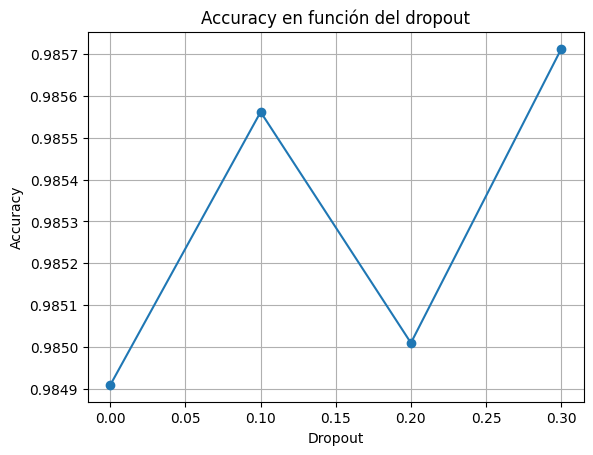

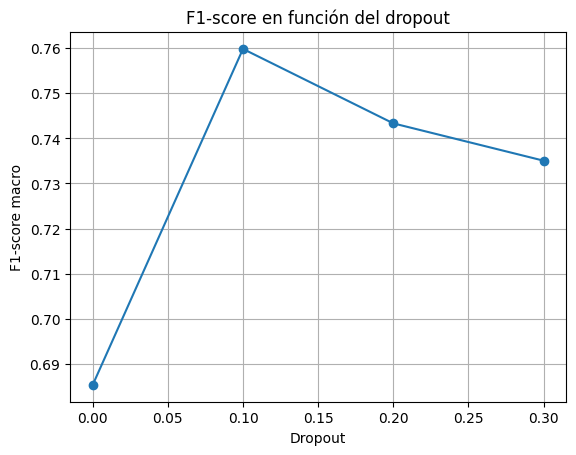

=== Classification report del MEJOR modelo (por F1_macro) ===
                              precision    recall  f1-score   support

             B-aircraft_code       0.00      0.00      0.00        21
              B-airline_code       1.00      0.76      0.86        29
              B-airline_name       0.93      0.86      0.89        79
              B-airport_code       0.60      0.38      0.46         8
              B-airport_name       0.73      0.44      0.55        18
 B-arrive_date.date_relative       1.00      1.00      1.00         1
      B-arrive_date.day_name       0.86      0.86      0.86         7
    B-arrive_date.day_number       1.00      0.67      0.80         3
    B-arrive_date.month_name       1.00      0.67      0.80         3
 B-arrive_time.period_of_day       1.00      1.00      1.00         2
    B-arrive_time.start_time       0.50      1.00      0.67         1
          B-arrive_time.time       0.85      0.85      0.85        13
 B-arrive_time.time_relativ

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
batch_size = 32
epochs     = 10

embedding_dim = 128
best_filters  = 32
best_kernel   = 3

RNN = 'GRU'
units_best      = 128


best_heads     = 8
best_ff_mult   = 2
best_tf_layers = 1

drop_rnn = [0.0,0.1, 0.2, 0.3]


sweep_results = []
best_f1 = -1.0

accuracies = []
f1_scores = []

for d in drop_rnn:

                    model = Sequential()

                    # Embedding con máscara para ignorar padding (id 0)
                    # model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                        # input_length=max_sequence_length, mask_zero=True))

                    model.add(TokenAndPositionEmbedding(max_sequence_length, vocab_size, embedding_dim))

                    model.add(Dropout(d))
                    for _ in range(best_tf_layers):
                        model.add(TransformerBlock(embed_dim=embedding_dim,
                                           num_heads=best_heads,
                                           ff_dim=best_ff_mult*embedding_dim,
                                           rate=0.1))



                    # Bloques recurrentes (todas con return_sequences=True para NER)

                    RNN_type = LSTM if RNN == 'LSTM' else GRU
                    model.add(Bidirectional(RNN_type(units=units_best, return_sequences=True)))



                    model.add(Dense(128, activation='relu'))

                    model.add(Dropout(d))
                    # Salida por token
                    model.add(Dense(num_unique_entities, activation='softmax'))

                    # Compilación (usa 'sparse_categorical_crossentropy' si tus y son enteros)
                    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                    model.fit(
                      train_pad_sequences, train_labels_one_hot,

                      validation_data=(val_pad_sequences, val_labels_one_hot),
                      batch_size=batch_size, epochs=epochs, verbose=0
                  )
                    loss, acc = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size, verbose=0)
                    preds = model.predict(test_pad_sequences, batch_size=batch_size, verbose=0)

                    test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
                    preds_idx = preds_to_index(preds, len_test_sequences)
                    labels_to_use = [lbl for lbl in set(test_labels_idx) if lbl != 119]

                    rep = classification_report(
                    test_labels_idx, preds_idx,
                    labels=labels_to_use,
                    target_names=[label_encoder.classes_[i] for i in labels_to_use],
                    zero_division=1.0,
                    output_dict=True
                    )
                    f1_macro = rep['macro avg']['f1-score']

                    sweep_results.append({
                        'rnn_dropout': d,
                        'Accuracy_test': acc,
                        'F1_macro': f1_macro

                    })
                    if f1_macro > best_f1:
                                  best_f1 = f1_macro
                                  best_report_text = classification_report(
                                      test_labels_idx, preds_idx,
                                      labels=labels_to_use,
                                      target_names=[label_encoder.classes_[i] for i in labels_to_use],
                                      zero_division=1.0
                                  )
                    accuracies.append(acc)
                    f1_scores.append(f1_macro)

df_drop = pd.DataFrame(sweep_results)
display(df_drop)


plt.plot(drop_rnn, accuracies, marker='o')
plt.title('Accuracy en función del dropout')
plt.xlabel('Dropout')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

plt.plot(drop_rnn, f1_scores, marker='o')
plt.title('F1-score en función del dropout')
plt.xlabel('Dropout')
plt.ylabel('F1-score macro')
plt.grid(True)
plt.show()





print("=== Classification report del MEJOR modelo (por F1_macro) ===")
print(best_report_text)


### Balancejat de classes

In [13]:
import numpy as np
from collections import Counter

batch_size = 32
epochs = 10
vocab_size = len(tokenizer.word_index) + 1


embedding_dim = 128
best_filters  = 32
best_kernel   = 3

RNN = 'GRU'
units_best      = 128


best_heads     = 8
best_ff_mult   = 2
best_tf_layers = 1

drop = 0.1

# 1. Calcular frecuencias
train_labels_flat = np.argmax(train_labels_one_hot, axis=-1).flatten()
class_counts = Counter(train_labels_flat)

print("Distribución de clases:")
for class_id, count in sorted(class_counts.items()):
    print(f"Clase {class_id}: {count} ({count/len(train_labels_flat)*100:.2f}%)")

# 2. ESTRATEGIA MEJORADA: Pesos más suaves con límites
O_CLASS_ID = 119
total_samples = len(train_labels_flat)
class_weights_array = np.ones(num_unique_entities)

# Parámetros ajustables
O_WEIGHT = [0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]         # Peso muy bajo para clase O
MAX_WEIGHT = 10.0       # Límite máximo para clases muy raras
MIN_SAMPLES_CAP = 5     # Clases con menos de 5 samples se limitan

for o_weight in O_WEIGHT:

  for i in range(num_unique_entities):
      if i in class_counts:
          count = class_counts[i]

          if i == O_CLASS_ID:
              # Peso muy bajo para "O"
              class_weights_array[i] = o_weight
          else:
              # Calcular peso inversamente proporcional
              weight = total_samples / (len(class_counts) * count)

              # Limitar clases muy raras
              if count < MIN_SAMPLES_CAP:
                  weight = min(weight, MAX_WEIGHT)

              class_weights_array[i] = weight
      else:
          # Clases que no aparecen
          class_weights_array[i] = 1.0

  # NO normalizar - mantener la escala relativa
  # print("\nPesos finales por clase:")
  stats = []
  for i, weight in enumerate(class_weights_array):
      count = class_counts.get(i, 0)
      if count > 0:
          stats.append((i, weight, count))

  # Mostrar solo algunas clases importantes
  print("\n Clase O:", class_weights_array[O_CLASS_ID])
  # print("\nClases más frecuentes (top 10):")
  # for i, w, c in sorted(stats, key=lambda x: x[2], reverse=True)[:10]:
  #     print(f"  Clase {i}: peso={w:.3f}, samples={c}")
  # print("\nClases más raras (bottom 10):")
  # for i, w, c in sorted(stats, key=lambda x: x[2])[:10]:
  #     print(f"  Clase {i}: peso={w:.3f}, samples={c}")

  # 3. Loss personalizada
  import tensorflow as tf
  from tensorflow.keras import backend as K

  def weighted_categorical_crossentropy(class_weights):
      class_weights = K.constant(class_weights, dtype=K.floatx())

      def loss(y_true, y_pred):
          y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
          ce = -y_true * K.log(y_pred)
          weighted_ce = ce * class_weights
          return K.mean(K.sum(weighted_ce, axis=-1))

      return loss

  # 4. Reconstruir y compilar modelo
  # IMPORTANTE: Volver a crear el modelo desde cero
  model = Sequential()
  model.add(TokenAndPositionEmbedding(max_sequence_length, vocab_size, embedding_dim))
  model.add(Dropout(drop))

  for _ in range(best_tf_layers):
      model.add(TransformerBlock(embed_dim=embedding_dim,
                          num_heads=best_heads,
                          ff_dim=best_ff_mult*embedding_dim,
                          rate=0.1))

  RNN_type = LSTM if RNN == 'LSTM' else GRU
  model.add(Bidirectional(RNN_type(units=units_best, return_sequences=True)))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(drop))
  model.add(Dense(num_unique_entities, activation='softmax'))

  # Compilar con loss ponderada
  model.compile(
      optimizer='adam',
      loss=weighted_categorical_crossentropy(class_weights_array),
      metrics=['accuracy']
  )

  print("\n" + "="*50)
  print("Entrenando modelo con pesos ajustados...")
  print("="*50)

  # 5. Entrenar
  history = model.fit(
      train_pad_sequences,
      train_labels_one_hot,
      validation_data=(val_pad_sequences, val_labels_one_hot),
      batch_size=batch_size,
      epochs=epochs,
      verbose=1
  )

  # 6. Evaluar
  loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot,
                                  batch_size=batch_size, verbose=0)
  print(f"\nTest accuracy: {accuracy:.4f}, loss: {loss:.4f}")

  # 7. Métricas detalladas (ignorando clase O)
  y_pred = model.predict(test_pad_sequences, verbose=0)
  y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
  y_true_classes = np.argmax(test_labels_one_hot, axis=-1).flatten()

  # Métricas sin la clase O
  mask = y_true_classes != O_CLASS_ID
  y_true_entities = y_true_classes[mask]
  y_pred_entities = y_pred_classes[mask]

  if len(y_true_entities) > 0:
      from sklearn.metrics import precision_recall_fscore_support, accuracy_score

      acc_entities = accuracy_score(y_true_entities, y_pred_entities)
      precision, recall, f1, _ = precision_recall_fscore_support(
          y_true_entities, y_pred_entities, average='macro', zero_division=0
      )

      print(f"\n{'='*50}")
      print("MÉTRICAS SOLO EN ENTIDADES (sin clase O):")
      print(f"{'='*50}")
      print(f"Accuracy:  {acc_entities:.4f}")
      print(f"Precision: {precision:.4f}")
      print(f"Recall:    {recall:.4f}")
      print(f"F1-Score:  {f1:.4f}")



Distribución de clases:
Clase 1: 27 (0.01%)
Clase 2: 114 (0.06%)
Clase 3: 575 (0.31%)
Clase 4: 21 (0.01%)
Clase 5: 33 (0.02%)
Clase 6: 10 (0.01%)
Clase 7: 70 (0.04%)
Clase 8: 40 (0.02%)
Clase 9: 40 (0.02%)
Clase 10: 1 (0.00%)
Clase 11: 15 (0.01%)
Clase 12: 3 (0.00%)
Clase 13: 50 (0.03%)
Clase 14: 16 (0.01%)
Clase 15: 178 (0.10%)
Clase 16: 161 (0.09%)
Clase 17: 177 (0.10%)
Clase 18: 177 (0.10%)
Clase 19: 33 (0.02%)
Clase 20: 273 (0.15%)
Clase 21: 5 (0.00%)
Clase 22: 2 (0.00%)
Clase 23: 3 (0.00%)
Clase 24: 65 (0.04%)
Clase 25: 745 (0.41%)
Clase 26: 316 (0.17%)
Clase 27: 303 (0.17%)
Clase 28: 66 (0.04%)
Clase 29: 22 (0.01%)
Clase 30: 22 (0.01%)
Clase 31: 29 (0.02%)
Clase 32: 491 (0.27%)
Clase 33: 22 (0.01%)
Clase 34: 307 (0.17%)
Clase 35: 271 (0.15%)
Clase 36: 31 (0.02%)
Clase 37: 47 (0.03%)
Clase 38: 64 (0.03%)
Clase 39: 32 (0.02%)
Clase 40: 275 (0.15%)
Clase 41: 64 (0.03%)
Clase 42: 140 (0.08%)
Clase 43: 61 (0.03%)
Clase 44: 11 (0.01%)
Clase 45: 66 (0.04%)
Clase 46: 3549 (1.93%)
Clase 4

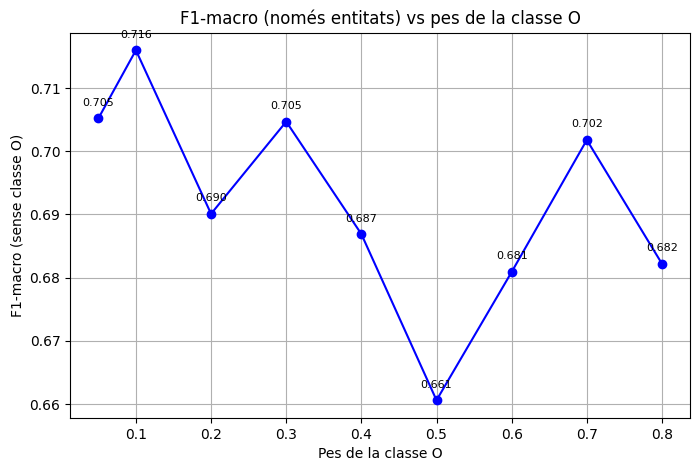

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Taula amb els valors
df = pd.DataFrame({
    "O_weight": [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80],
    "F1_macro_entities": [0.7052, 0.7160, 0.6901, 0.7047, 0.6869, 0.6606, 0.6809, 0.7018, 0.6822]
})

plt.figure(figsize=(8,5))
plt.plot(df["O_weight"], df["F1_macro_entities"], marker="o", color='blue')
plt.title("F1-macro (només entitats) vs pes de la classe O")
plt.xlabel("Pes de la classe O")
plt.ylabel("F1-macro (sense classe O)")
plt.grid(True)

# Afegir etiquetes als punts
for i, row in df.iterrows():
    plt.text(row["O_weight"], row["F1_macro_entities"] + 0.002, f"{row['F1_macro_entities']:.3f}",
             ha='center', fontsize=8)

plt.show()


---

<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---